In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import nltk
from datetime import datetime
import time
import datetime
import re
import random

In [273]:
df = pd.read_csv('tweets_public.csv', index_col='tweet_id')
df_submission = pd.read_csv('tweets_submission.csv', index_col='tweet_id')

In [274]:
#df_neg = df.query('airline_sentiment == "negative"').sample(frac=0.3)# and \airline_sentiment_confidence >= 0.5 and negativereason_confidence >= 0.5')
#df_neu = df.query('airline_sentiment == "neutral"')#.sample(frac = 3,replace = True)# and airline_sentiment_confidence >= 0.5')
#df_pos = df.query('airline_sentiment == "positive"')#.sample(frac = 4,replace = True)# and airline_sentiment_confidence >= 0.5')
#frames = [df_neg,df_neu,df_pos]
#print(len(df_neg),len(df_neu),len(df_pos))
#df = pd.concat(frames)
#print(len(df))

In [275]:
print(df.columns)
print(df_submission.columns)

Index(['airline_sentiment', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')
Index(['airline', 'name', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')


In [276]:
tweet_created = [tweet.split(' ')[0] for tweet in df.tweet_created.values]
df.tweet_created = tweet_created
tweet_created_submission = [tweet.split(' ')[0] for tweet in df_submission.tweet_created.values]
df_submission.tweet_created = tweet_created_submission

In [277]:
def processTweet2(tweet):
    # process the tweets

    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #tweet = re.sub(r'\#\w+','',tweet)
    return tweet  

def handle_emojis(tweet):
    tweet = re.sub(r'CC:', ' EMOPOS ', tweet)
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMOPOS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMOPOS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMOPOS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMOPOS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMONEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMONEG ', tweet)
    return tweet

def preprocess_word(word):
    # Remove punctuation
    #word = word.strip('\'"?!,.():;')
    word = word.strip('\'"?!,.')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    # remove numbers
    word = re.sub(r'\d+','',word)
    #remove users 
    word = re.sub(r'AT_USER','',word)
    word = re.sub(r'URL','',word)
    word = re.sub(r'rt','',word)
    word = re.sub(r'via','',word)
    return word

def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

In [278]:
tweets = [handle_emojis(tweet) for tweet in df.text.values]
tweets2 = [processTweet2(tweet) for tweet in tweets]
tweets3 = [' '.join(preprocess_word(word) for word in tweet.split(' ')) for tweet in tweets2]
df.text = tweets3
df.text.values

array([' ive been in pricing for  years to know that  bucks a seat is criminal  i understand pricing flying jetblue pricewise',
       ' ah  did dm no reply on hold now over hrs just spent over $k to get a united flight tmrw to get home lame',
       ' if you lost my belongings then be honest', ...,
       ' flight  to orlando',
       ' why not deal with that while the planes on the ground instead of diveing the plane &amp; adding  hrs to the flight',
       'see what you staed now    our fleets on fleek '], dtype=object)

In [279]:
sno = nltk.stem.SnowballStemmer('english')
tweet_1 = [' '.join(sno.stem(word) for word in tweet.split(' ')) for tweet in df.text.values]
lemma = nltk.wordnet.WordNetLemmatizer()
tweet_2 = [' '.join(lemma.lemmatize(word,pos='v') for word in tweet.split(' ')) for tweet in tweet_1]
df.text = [line.strip(' ') for line in tweet_2]
df.text.values

array(['ive be in price for  year to know that  buck a seat be crimin  i understand price fli jetblu pricewis',
       'ah  do dm no repli on hold now over hrs just spend over $k to get a unit flight tmrw to get home lame',
       'if you lose my belong then be honest', ..., 'flight  to orlando',
       'whi not deal with that while the plane on the grind instead of dive the plane &amp; ad  hrs to the flight',
       'see what you sta now    our fleet on fleek'], dtype=object)

In [280]:
tweets_submission = [handle_emojis(tweet) for tweet in df_submission.text.values]
tweets2_submission = [processTweet2(tweet) for tweet in tweets_submission]
tweets3_submission = [' '.join(preprocess_word(word) for word in tweet.split(' ')) for tweet in tweets2_submission]
tweet4_submission = [' '.join(sno.stem(word) for word in tweet.split(' ')) for tweet in tweets3_submission]
tweet5_submission = [' '.join(lemma.lemmatize(word,pos = 'v') for word in tweet.split(' ')) for tweet in tweet4_submission]
df_submission.text = [line.strip(' ') for line in tweet5_submission]
df_submission.text.values

array(['ua just land',
       'not happi wife th bday trip would like to be fulli compens for both flight',
       'not to mention it a three hour wait to get an agent on the phone',
       ..., 'of cours',
       'no i dont speak with baggag contact at  number say they will tri to get bag to stay at iad for pick up tmrw',
       'what go on with flight  delay beyond  shouldnt thre flight switch at that point'],
      dtype=object)

In [281]:
#df_neu = df.query('airline_sentiment == "neutral"')#.sample(frac = 3,replace = True)# and airline_sentiment_confidence >= 0.5')
##' '.join(random.sample(df.text.values[0].split(' '),len(df.text.values[0].split(' '))))
#print(len(df_neu))
#print(df_neu.text.values[0],df_neu.airline_sentiment.values[0])
#df_neu_append = pd.DataFrame()
#for j in range(2):
#    for i in range(len(df_neu)):
#        sentiment = df_neu.airline_sentiment.values[i]
#        text = df_neu.text.values[i]
#        airline_name = df_neu.airline.values[i]
#        new_text = ' '.join(random.sample(text.split(' '),len(text.split(' '))))
#        df_neu_append = df_neu_append.append(pd.DataFrame(data = {'text':new_text,'airline':airline_name,\
#                                                              'airline_sentiment':sentiment},index = [i]))
#print(len(df_neu_append))
#print(df_neu_append.text.values[0],df_neu_append.airline_sentiment.values[0])
#
#
#df_pos = df.query('airline_sentiment == "positive"')#.sample(frac = 3,replace = True)# and airline_sentiment_confidence >= 0.5')
##' '.join(random.sample(df.text.values[0].split(' '),len(df.text.values[0].split(' '))))
#print(len(df_pos))
#print(df_pos.text.values[0],df_pos.airline_sentiment.values[0])
#df_pos_append = pd.DataFrame()
#for j in range(3):
#    for i in range(len(df_pos)):
#        sentiment = df_pos.airline_sentiment.values[i]
#        text = df_pos.text.values[i]
#        airline_name = df_pos.airline.values[i]
#        new_text = ' '.join(random.sample(text.split(' '),len(text.split(' '))))
#        df_pos_append = df_pos_append.append(pd.DataFrame(data = {'text':new_text,'airline':airline_name,\
#                                                              'airline_sentiment':sentiment},index = [i]))
#print(len(df_pos_append))
#print(df_pos_append.text.values[0],df_pos_append.airline_sentiment.values[0])

In [282]:
#df_neu = df_neu.append(df_neu_append)
#df_pos = df_pos.append(df_pos_append)
#frames = [df_neg,df_neu,df_pos]
#df = pd.concat(frames)
#print(len(df_neg),len(df_neu),len(df_pos))
#print(len(df))

In [283]:
for i in np.unique(np.array(df['airline'])):
    ind = df.query('airline == @i').index
    df.loc[ind,i] = 1
american = np.array(df['American'].fillna(value = 0))
delta = np.array(df['Delta'].fillna(value = 0))
south = np.array(df['Southwest'].fillna(value = 0))
usair = np.array(df['US Airways'].fillna(value = 0))
united = np.array(df['United'].fillna(value = 0))
virgin = np.array(df['Virgin America'].fillna(value = 0))

In [284]:
for i in np.unique(np.array(df['tweet_created'])):
    ind = df.query('tweet_created == @i').index
    df.loc[ind,i] = 1
day1 = np.array(df['2015-02-16'].fillna(value = 0))
day2 = np.array(df['2015-02-17'].fillna(value = 0))
day3 = np.array(df['2015-02-18'].fillna(value = 0))
day4 = np.array(df['2015-02-19'].fillna(value = 0))
day5 = np.array(df['2015-02-20'].fillna(value = 0))
day6 = np.array(df['2015-02-21'].fillna(value = 0))
day7 = np.array(df['2015-02-22'].fillna(value = 0))
day8 = np.array(df['2015-02-23'].fillna(value = 0))
day9 = np.array(df['2015-02-24'].fillna(value = 0))

In [285]:
#j = 0
#df['user_timezone'] = df['user_timezone'].fillna(value = '0')
#for i in np.unique(np.array(df['user_timezone'])):
#    ind = df.query('user_timezone == @i').index
#    df.loc[ind,i] = 1
#    locals()["a"+str(j)] =np.array(df[str(i)].fillna(value = 0))
#    j = j + 1

In [286]:
for i in np.unique(np.array(df_submission['airline'])):
    ind = df_submission.query('airline == @i').index
    df_submission.loc[ind,i] = 1
american_submission = np.array(df_submission['American'].fillna(value = 0))
delta_submission = np.array(df_submission['Delta'].fillna(value = 0))
south_submission = np.array(df_submission['Southwest'].fillna(value = 0))
usair_submission = np.array(df_submission['US Airways'].fillna(value = 0))
united_submission = np.array(df_submission['United'].fillna(value = 0))
virgin_submission = np.array(df_submission['Virgin America'].fillna(value = 0))

In [287]:
for i in np.unique(np.array(df_submission['tweet_created'])):
    ind = df_submission.query('tweet_created == @i').index
    df_submission.loc[ind,i] = 1
day1_submission = np.array(df_submission['2015-02-16'].fillna(value = 0))
day2_submission = np.array(df_submission['2015-02-17'].fillna(value = 0))
day3_submission = np.array(df_submission['2015-02-18'].fillna(value = 0))
day4_submission = np.array(df_submission['2015-02-19'].fillna(value = 0))
day5_submission = np.array(df_submission['2015-02-20'].fillna(value = 0))
day6_submission = np.array(df_submission['2015-02-21'].fillna(value = 0))
day7_submission = np.array(df_submission['2015-02-22'].fillna(value = 0))
day8_submission = np.array(df_submission['2015-02-23'].fillna(value = 0))
day9_submission = np.array(df_submission['2015-02-24'].fillna(value = 0))

In [288]:
#j = 0
#df_submission['user_timezone'] = df_submission['user_timezone'].fillna(value = '0')
#for i in np.unique(np.array(df_submission['user_timezone'])):
#    ind = df_submission.query('user_timezone == @i').index
#    df_submission.loc[ind,i] = 1
#    locals()["a_submission"+str(j)] =np.array(df_submission[str(i)].fillna(value = 0))
#    j = j + 1

In [289]:
count_vect = CountVectorizer(ngram_range=(1,2),token_pattern=r'\b\w+\b')
X_train_counts = count_vect.fit_transform(df.text.values)
voc = count_vect.vocabulary_
print(X_train_counts.shape)
X_train_counts = X_train_counts.toarray()

(8784, 62797)


In [290]:
X_train_counts = np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((X_train_counts,american)),delta)),south)),usair)),united)),virgin))

In [291]:
print(X_train_counts.shape)

(8784, 62803)


In [292]:
X_train_counts = np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((X_train_counts,day1)),day2)),day3)),day4)),day5)),day6)),day7)),day8)),day9))

In [293]:
print(X_train_counts.shape)

(8784, 62812)


In [294]:
#for i in range(79):
#    to_app = locals()["a"+str(i)]
#    X_train_counts = np.column_stack((X_train_counts,to_app))

In [295]:
print(X_train_counts.shape)

(8784, 62812)


In [296]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)
#X_train_array = X_train_tfidf.toarray()

(8784, 62812)


In [297]:
#X_resampled, y_resampled = ADASYN().fit_sample(X_train_tfidf, df.airline_sentiment.values)

In [265]:
#print(X_resampled.shape,y_resampled.shape)

In [298]:
features_train,features_test,label_train,label_test = \
train_test_split(X_train_tfidf, df.airline_sentiment.values,test_size=0.15,random_state = 123)
sgc = SGDClassifier(penalty = 'elasticnet',max_iter = 10)
svm = LinearSVC()
sgc.fit(features_train,label_train)
svm.fit(features_train,label_train)
score = sgc.score(features_test,label_test)
scoresvm = svm.score(features_test,label_test)
print(score)
print(scoresvm)

0.9123232323232323
0.9535353535353536


classification accuracy: 0.9123232323232323


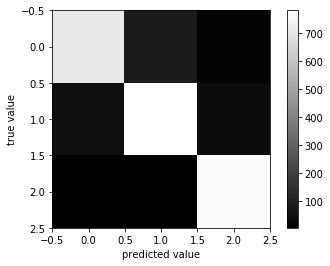

             precision    recall  f1-score   support

   negative       0.92      0.87      0.89       815
    neutral       0.89      0.89      0.89       877
   positive       0.93      0.98      0.95       783

avg / total       0.91      0.91      0.91      2475

classification accuracy: 0.9535353535353536


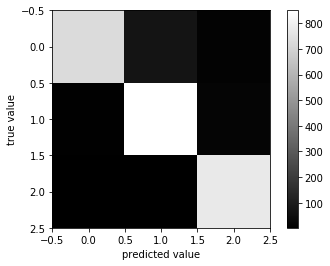

             precision    recall  f1-score   support

   negative       0.99      0.90      0.94       815
    neutral       0.92      0.97      0.95       877
   positive       0.96      0.99      0.97       783

avg / total       0.96      0.95      0.95      2475



In [299]:
def plot_confusion_matrix(y, y_pred):
    plt.imshow(metrics.confusion_matrix(y, y_pred),
               cmap=plt.cm.gray, interpolation='nearest')
    plt.colorbar()
    plt.ylabel('true value')
    plt.xlabel('predicted value')
    plt.show()
    
print ("classification accuracy:", metrics.accuracy_score(label_test, sgc.predict(features_test)))
plot_confusion_matrix(label_test, sgc.predict(features_test))
print(metrics.classification_report(label_test,sgc.predict(features_test)))

print ("classification accuracy:", metrics.accuracy_score(label_test, svm.predict(features_test)))
plot_confusion_matrix(label_test, svm.predict(features_test))
print(metrics.classification_report(label_test,svm.predict(features_test)))

In [302]:
svm.fit(X_train_tfidf, df.airline_sentiment.values)
count_vect = CountVectorizer(vocabulary=voc,ngram_range=(1,2),token_pattern=r'\b\w+\b')
X_test_counts = count_vect.fit_transform(df_submission.text.values)
X_test_counts = X_test_counts.toarray()
X_test_counts = np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((X_test_counts,american_submission))\
                                  ,delta_submission)),south_submission))\
                                  ,usair_submission)),united_submission))\
                                 ,virgin_submission))
X_test_counts = np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((\
                 np.column_stack((X_test_counts,day1_submission)),day2_submission))\
                                  ,day3_submission)),day4_submission)),day5_submission))\
                                  ,day6_submission)),day7_submission)),day8_submission)),day9_submission))
#for i in range(56):
#    to_app = locals()["a_submission"+str(i)]
#    X_test_counts = np.column_stack((X_test_counts,to_app))
#for i in range(23):
#    X_test_counts = np.column_stack((X_test_counts,np.zeros(X_test_counts.shape[0])))
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
prediction = svm.predict(X_test_tfidf)

In [303]:
def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y-%H_%M_%S")
    filename = 'submission_' + date + '.csv'

    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)

    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')
#prediction[prediction == 0] = "negative"
#prediction[prediction == 1] = "neutral"
#prediction[prediction == 2] = "positive"
create_submit_file(df_submission,prediction)

Submission file created: submission_02_15_2018-16_13_47.csv
Upload it to Kaggle InClass
